In [1]:
from tsai.all import *
import sklearn.metrics as skm

from IPython.display import clear_output
computer_setup()

c:\Users\lucki\anaconda3\envs\stylegan\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


os              : Windows-10-10.0.22621-SP0
python          : 3.8.15
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.9.1+cu111
device          : 1 gpu (['NVIDIA GeForce RTX 2070 SUPER'])
cpu cores       : 8
threads per cpu : 2
RAM             : 31.92 GB
GPU memory      : [8.0] GB


### Resteaze Data

In [41]:
# Read the data
data = pd.read_csv('final_processed.csv', index_col=0)

data.tail()

,time,accelerometerX,accelerometerY,accelerometerZ,gyroscopeX,gyroscopeY,gyroscopeZ,ledGreen,rmssd,sleep_state
18572996,2022-03-24 12:10:23.257,-2189.5,167.0,3401.0,18.0,-225.0,65.0,-7.840528,NaN,2.0
18572997,2022-03-24 12:10:23.258,-2191.0,163.0,3402.0,22.0,-229.0,58.0,-8.442375,NaN,2.0
18572998,2022-03-24 12:10:23.297,-2188.5,162.0,3404.0,21.0,-229.5,55.5,-9.351681,NaN,2.0
18572999,2022-03-24 12:10:23.298,-2186.0,161.0,3406.0,20.0,-230.0,53.0,-10.222269,NaN,2.0
18573000,2022-03-24 12:10:23.337,-2187.0,164.5,3402.5,20.5,-224.0,50.5,-10.753995,55.922024,2.0


In [64]:
df = data.copy()

df = df[df.sleep_state != -1]

# Binary Classification
df["sleep_state"] = np.where(df["sleep_state"] == 0, 0, 1)

# fill NaN values
df = df.fillna(method='bfill', limit=1500).dropna()

# set column time as datetime index
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time', drop=True)


In [65]:
df

,accelerometerX,accelerometerY,accelerometerZ,gyroscopeX,gyroscopeY,gyroscopeZ,ledGreen,rmssd,sleep_state
time,,,,,,,,,
2022-02-16 06:08:26.261,38.0,303.0,4035.0,-229.0,-130.0,116.0,3.187132,108.529827,0
2022-02-16 06:08:26.269,41.0,305.5,4030.0,-235.5,-116.5,113.5,1.764316,108.529827,0
2022-02-16 06:08:26.301,44.0,308.0,4025.0,-242.0,-103.0,111.0,0.678930,108.529827,0
2022-02-16 06:08:26.309,40.0,307.5,4026.0,-240.5,-113.5,117.5,-0.037326,108.529827,0
2022-02-16 06:08:26.341,36.0,307.0,4027.0,-239.0,-124.0,124.0,-0.506104,108.529827,0
...,...,...,...,...,...,...,...,...,...
2022-03-24 12:10:23.257,-2189.5,167.0,3401.0,18.0,-225.0,65.0,-7.840528,55.922024,1
2022-03-24 12:10:23.258,-2191.0,163.0,3402.0,22.0,-229.0,58.0,-8.442375,55.922024,1
2022-03-24 12:10:23.297,-2188.5,162.0,3404.0,21.0,-229.5,55.5,-9.351681,55.922024,1


In [66]:
# Non null values in the dataset
df.isnull().sum()

accelerometerX    0
accelerometerY    0
accelerometerZ    0
gyroscopeX        0
gyroscopeY        0
gyroscopeZ        0
ledGreen          0
rmssd             0
sleep_state       0
dtype: int64

In [67]:
class_map = {
    0: 'WK',  # wake
    1: 'SL',  # sleep
}
class_map

{0: 'WK', 1: 'SL'}

<AxesSubplot:xlabel='time'>

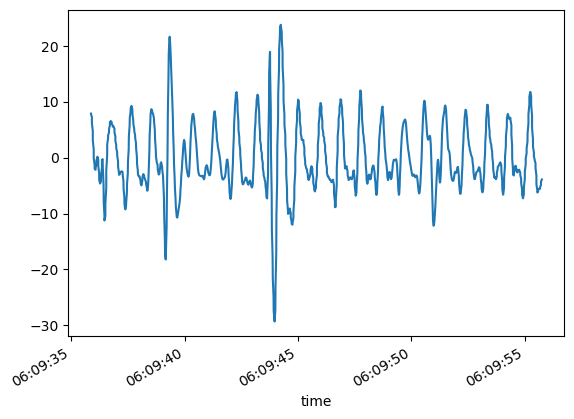

In [68]:
df['ledGreen'][2000:3000].plot()

# Filters and transforms

## TSData preparation

## Data from 3d array

In [69]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder


scaler = StandardScaler()
le = LabelEncoder()

temp_df = df[['accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'ledGreen', 'rmssd', 'sleep_state']]
X = scaler.fit_transform(temp_df.drop('sleep_state', axis=1))
y = le.fit_transform(temp_df['sleep_state'])

# selecting sequences range
X = X[0:(len(X) - len(X)%3000)]
y = y[0:(len(y) - len(y)%3000)]

pd.DataFrame(X)

,0,1,2,3,4,5,6,7
0,-0.890638,0.503296,1.527698,-0.463487,0.081429,0.101457,0.135530,0.052251
1,-0.889105,0.506983,1.526036,-0.483138,0.108131,0.094790,0.075031,0.052251
2,-0.887571,0.510669,1.524374,-0.502790,0.134834,0.088123,0.028880,0.052251
3,-0.889616,0.509932,1.524706,-0.498255,0.114065,0.105457,-0.001576,0.052251
4,-0.891660,0.509195,1.525039,-0.493720,0.093297,0.122792,-0.021508,0.052251
...,...,...,...,...,...,...,...,...
7982995,-2.030006,0.311591,1.316292,0.274204,-0.039226,-0.063886,-0.159168,-0.663343
7982996,-2.029495,0.305692,1.315461,0.240948,-0.077796,-0.065220,-0.168410,-0.663343
7982997,-2.028983,0.299794,1.314630,0.207691,-0.116366,-0.066553,-0.191597,-0.663343
7982998,-2.030517,0.296844,1.316458,0.234901,-0.113399,-0.058553,-0.235013,-0.663343


In [70]:
# epoch lenght 60 seconds (25hz * 60 = 1500)
# 12241 epochs
sht = len(X) // 3000
print("Shape: ", sht)

X = X.T.reshape(sht, 8, 3000)
y = y.T.reshape(sht, 3000)
y = (y.sum(axis=1) // 3000).reshape(-1, 1).flatten()

X.shape, y.shape

Shape:  2661


((2661, 8, 3000), (2661,))

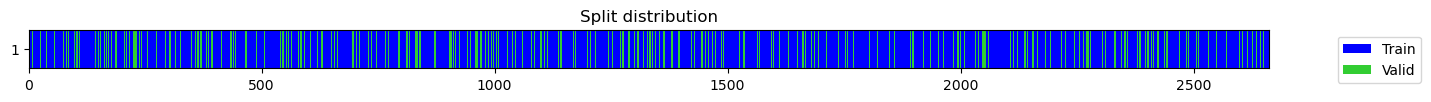

((#2129) [1692,2185,509,705,2648,1799,977,480,2338,2087...],
 (#532) [286,1319,2103,178,1038,729,2278,2292,1300,1660...])

In [71]:
splits = get_splits(y,
                    valid_size=.2,
                    stratify=True,
                    random_state=123,
                    shuffle=True)
splits

In [72]:
labeler = ReLabeler(class_map)
new_y = labeler(y) # map to more descriptive labels

X.shape, new_y.shape, splits, new_y

((2661, 8, 3000),
 (2661,),
 ((#2129) [1692,2185,509,705,2648,1799,977,480,2338,2087...],
  (#532) [286,1319,2103,178,1038,729,2278,2292,1300,1660...]),
 array(['WK', 'WK', 'WK', ..., 'SL', 'SL', 'SL'], dtype='<U2'))

In [73]:
label_counts = collections.Counter(new_y)
print('Counts by label:', dict(label_counts))
print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

Counts by label: {'WK': 1038, 'SL': 1623}
Naive Accuracy: 60.99%


In [74]:
tfms = [None, [TSClassification()]]  # TSClassification == Categorize
batch_tfms = TSStandardize()

## Dataloaders

In [75]:
dls = get_ts_dls(X, new_y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])
dls.dataset

(#2129) [(TSTensor(vars:8, len:3000, device=cpu, dtype=torch.float32), TensorCategory(0)), (TSTensor(vars:8, len:3000, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:8, len:3000, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:8, len:3000, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:8, len:3000, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:8, len:3000, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:8, len:3000, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:8, len:3000, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:8, len:3000, device=cpu, dtype=torch.float32), TensorCategory(1)), (TSTensor(vars:8, len:3000, device=cpu, dtype=torch.float32), TensorCategory(1))] ...]

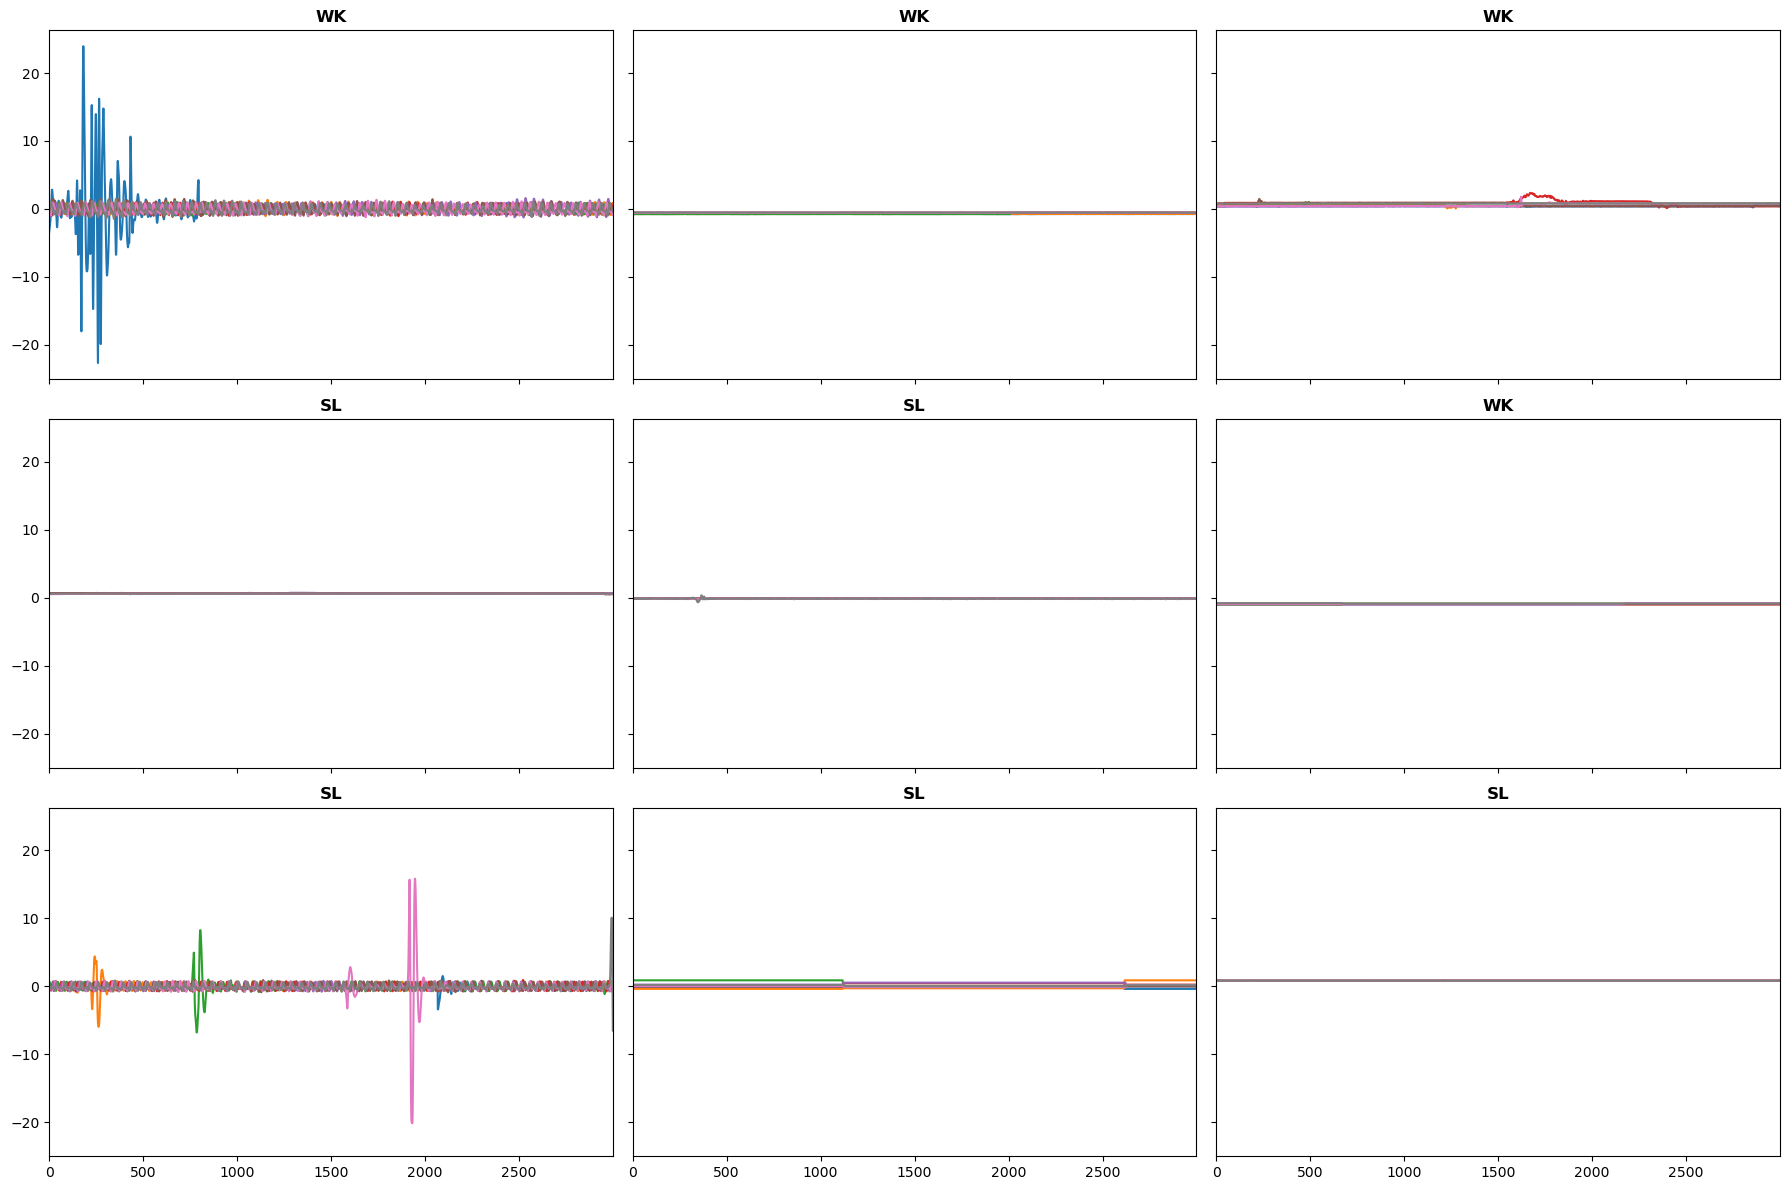

In [76]:
dls.show_batch(sharey=True)

## Build learner

In [77]:
archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}),
         (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}),
         (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
         (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4})]


for i, (arch, k) in enumerate(archs):
    print(f'arch: {arch.__name__}')

# results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
# for i, (arch, k) in enumerate(archs):
#     model = build_ts_model(arch, dls=dls, **k)
#     print(model.__class__.__name__)
#     learn = ts_learner(dls, model,  metrics=accuracy)
#     start = time.time()
#     learn.fit_one_cycle(5, 1e-3)
#     elapsed = time.time() - start
#     vals = learn.recorder.values[-1]
#     results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
#     results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
#     clear_output()
#     display(results)

arch: FCN
arch: ResNet
arch: xresnet1d34
arch: ResCNN
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM
arch: LSTM_FCN
arch: LSTM_FCN
arch: InceptionTime
arch: XceptionTime
arch: OmniScaleCNN
arch: mWDN


In [86]:
model = build_ts_model(InceptionTimePlus, dls=dls)

# model = build_ts_model(LSTM, dls=dls, **{})

metrics = [accuracy, Precision(), Recall(), F1Score()]
learn = ts_learner(dls, model, metrics=metrics, cbs=ShowGraph())

In [87]:
# learn = Learner(dls, model, metrics=accuracy)

## LR find

SuggestedLRs(valley=9.120108734350652e-05)

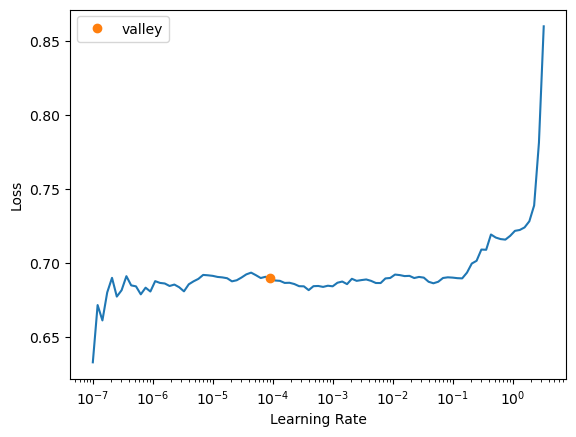

In [88]:
# learn.load('stage0')
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.681403,0.684370,0.603383,0.000000,0.000000,0.000000,00:13
1,0.670168,0.669025,0.599624,0.000000,0.000000,0.000000,00:12
2,0.660682,0.670223,0.597744,0.312500,0.024038,0.044643,00:12
3,0.653053,0.664606,0.618421,0.542373,0.153846,0.239700,00:12
4,0.648178,0.677830,0.599624,0.475248,0.230769,0.310680,00:12
5,0.643971,0.670066,0.605263,0.466667,0.067308,0.117647,00:12
6,0.641338,0.664228,0.627820,0.559524,0.225962,0.321918,00:12
7,0.634876,0.683065,0.605263,0.488095,0.197115,0.280822,00:13
8,0.629469,0.652146,0.633459,0.568421,0.259615,0.356436,00:13
9,0.625564,0.659453,0.603383,0.483146,0.206731,0.289562,00:13


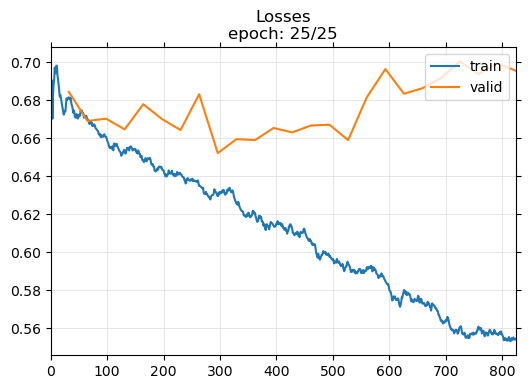

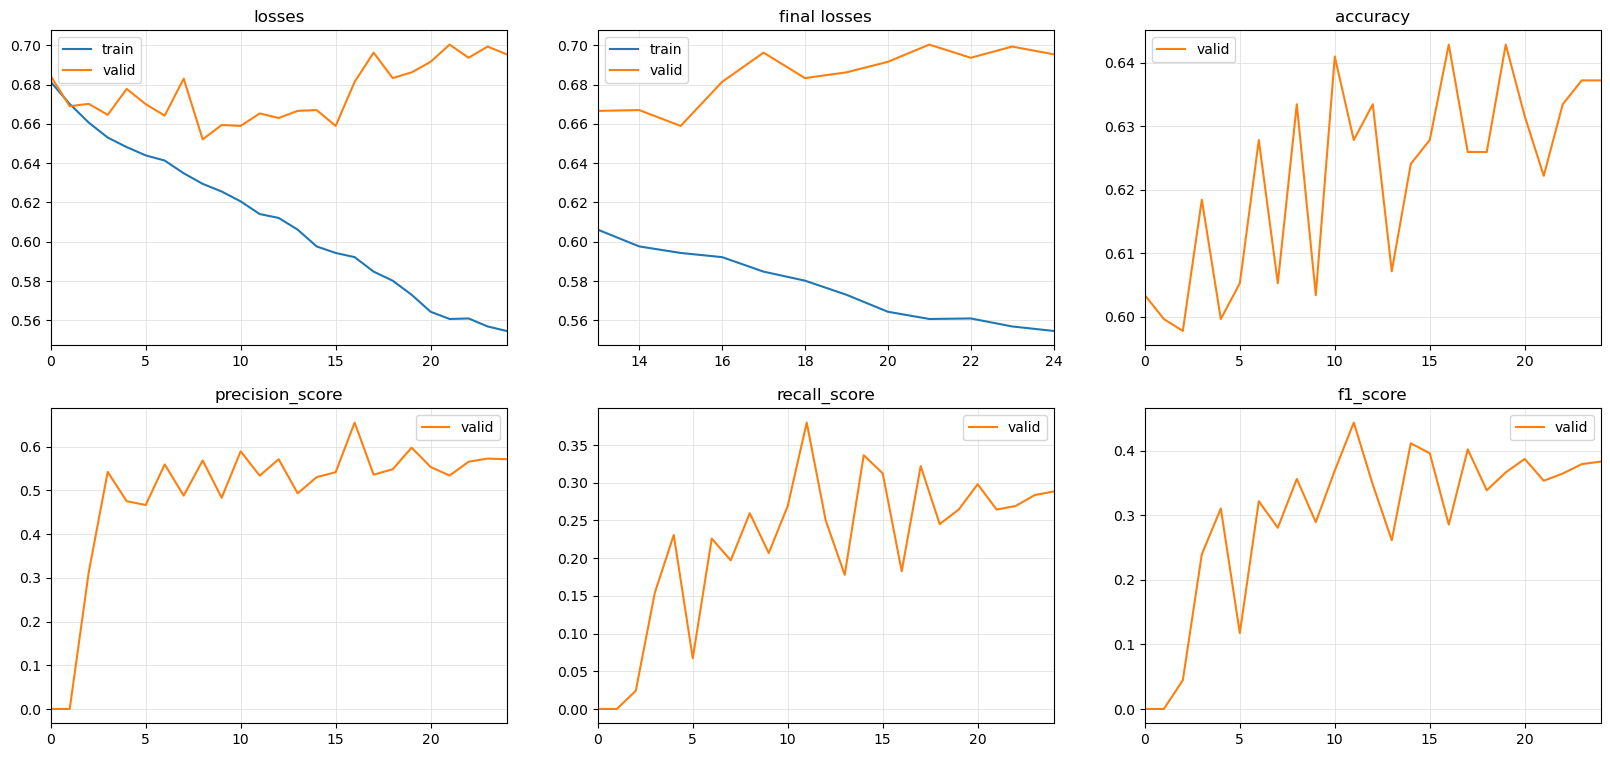

In [89]:
learn.fit_one_cycle(25, lr_max=1e-4)

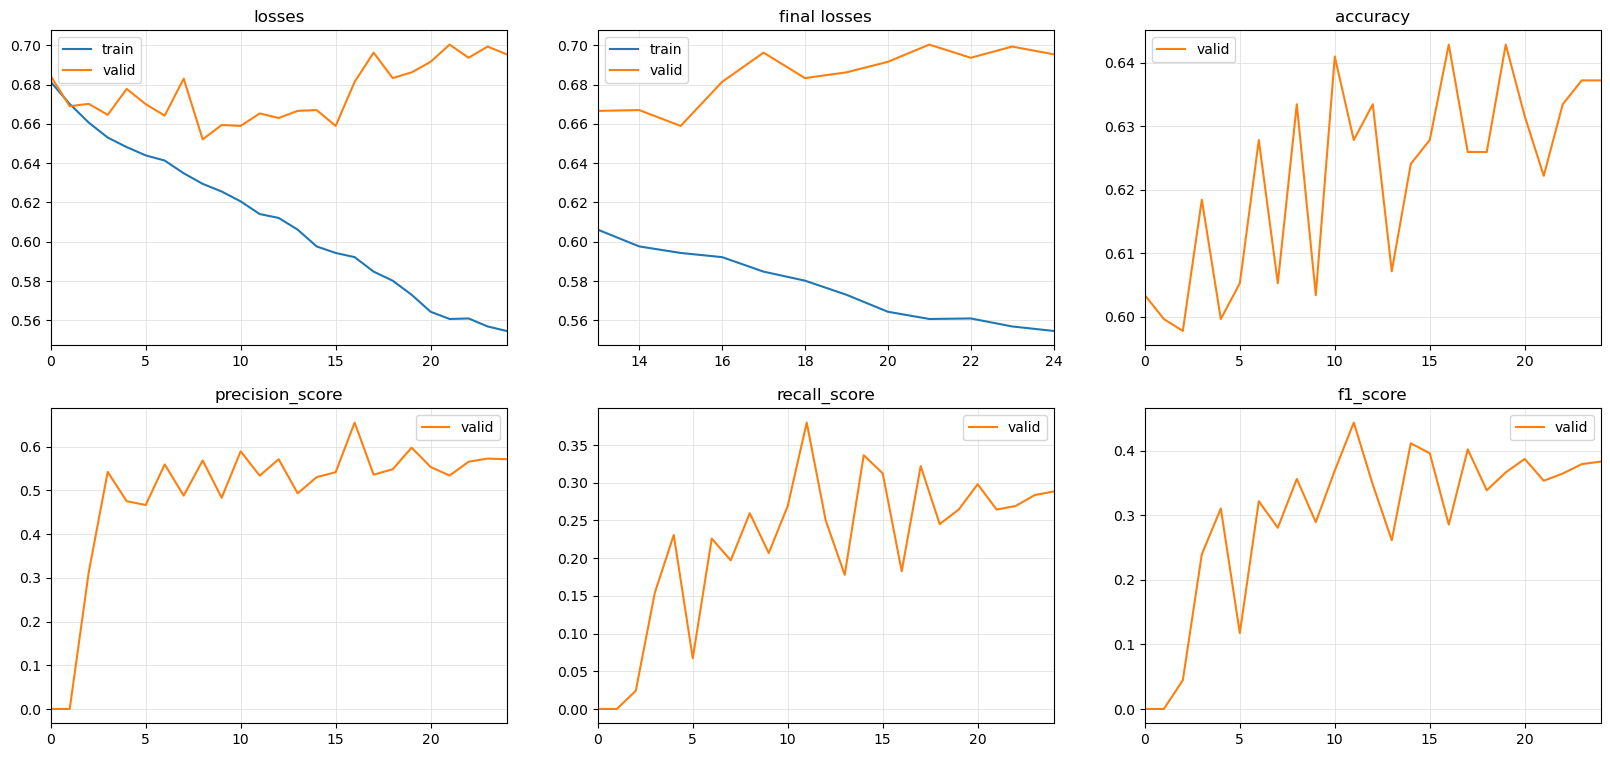

In [90]:
learn.plot_metrics()

## Transformers 

In [94]:
# model = TST(dls.vars, dls.c, dls.len, dropout=.3)
# learn = Learner(dls,
#                 model,
#                 loss_func=LabelSmoothingCrossEntropyFlat(),
#                 metrics=[RocAucBinary(), accuracy],
#                 cbs=ShowGraphCallback2())
# start = time.time()
# learn.fit_one_cycle(25, lr_max=1e-4)
# print('\nElapsed time:', time.time() - start)
# learn.plot_metrics()
# beep()

##### Save model

In [100]:
learn.save('rmmsd')

In [101]:
learn.save_all(path='export_rmmsd',
               dls_fname='dls',
               model_fname='model',
               learner_fname='learner')

## Inferece


In [4]:
learn = load_learner_all(path='export_rmmsd',
                         dls_fname='dls',
                         model_fname='model',
                         learner_fname='learner')

dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:128, vars:8, len:3000, device=cuda:0, dtype=torch.float32),
 TensorCategory([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
         0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
         0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
         0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
         1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
         1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0'))

In [5]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl,
                                                           with_decoded=True)
valid_probas, valid_targets, valid_preds

RuntimeError: CUDA out of memory. Tried to allocate 68.67 GiB (GPU 0; 8.00 GiB total capacity; 2.37 GiB already allocated; 3.83 GiB free; 2.51 GiB reserved in total by PyTorch)

In [ ]:
(valid_targets == valid_preds).float().mean()

tensor(0.4038)

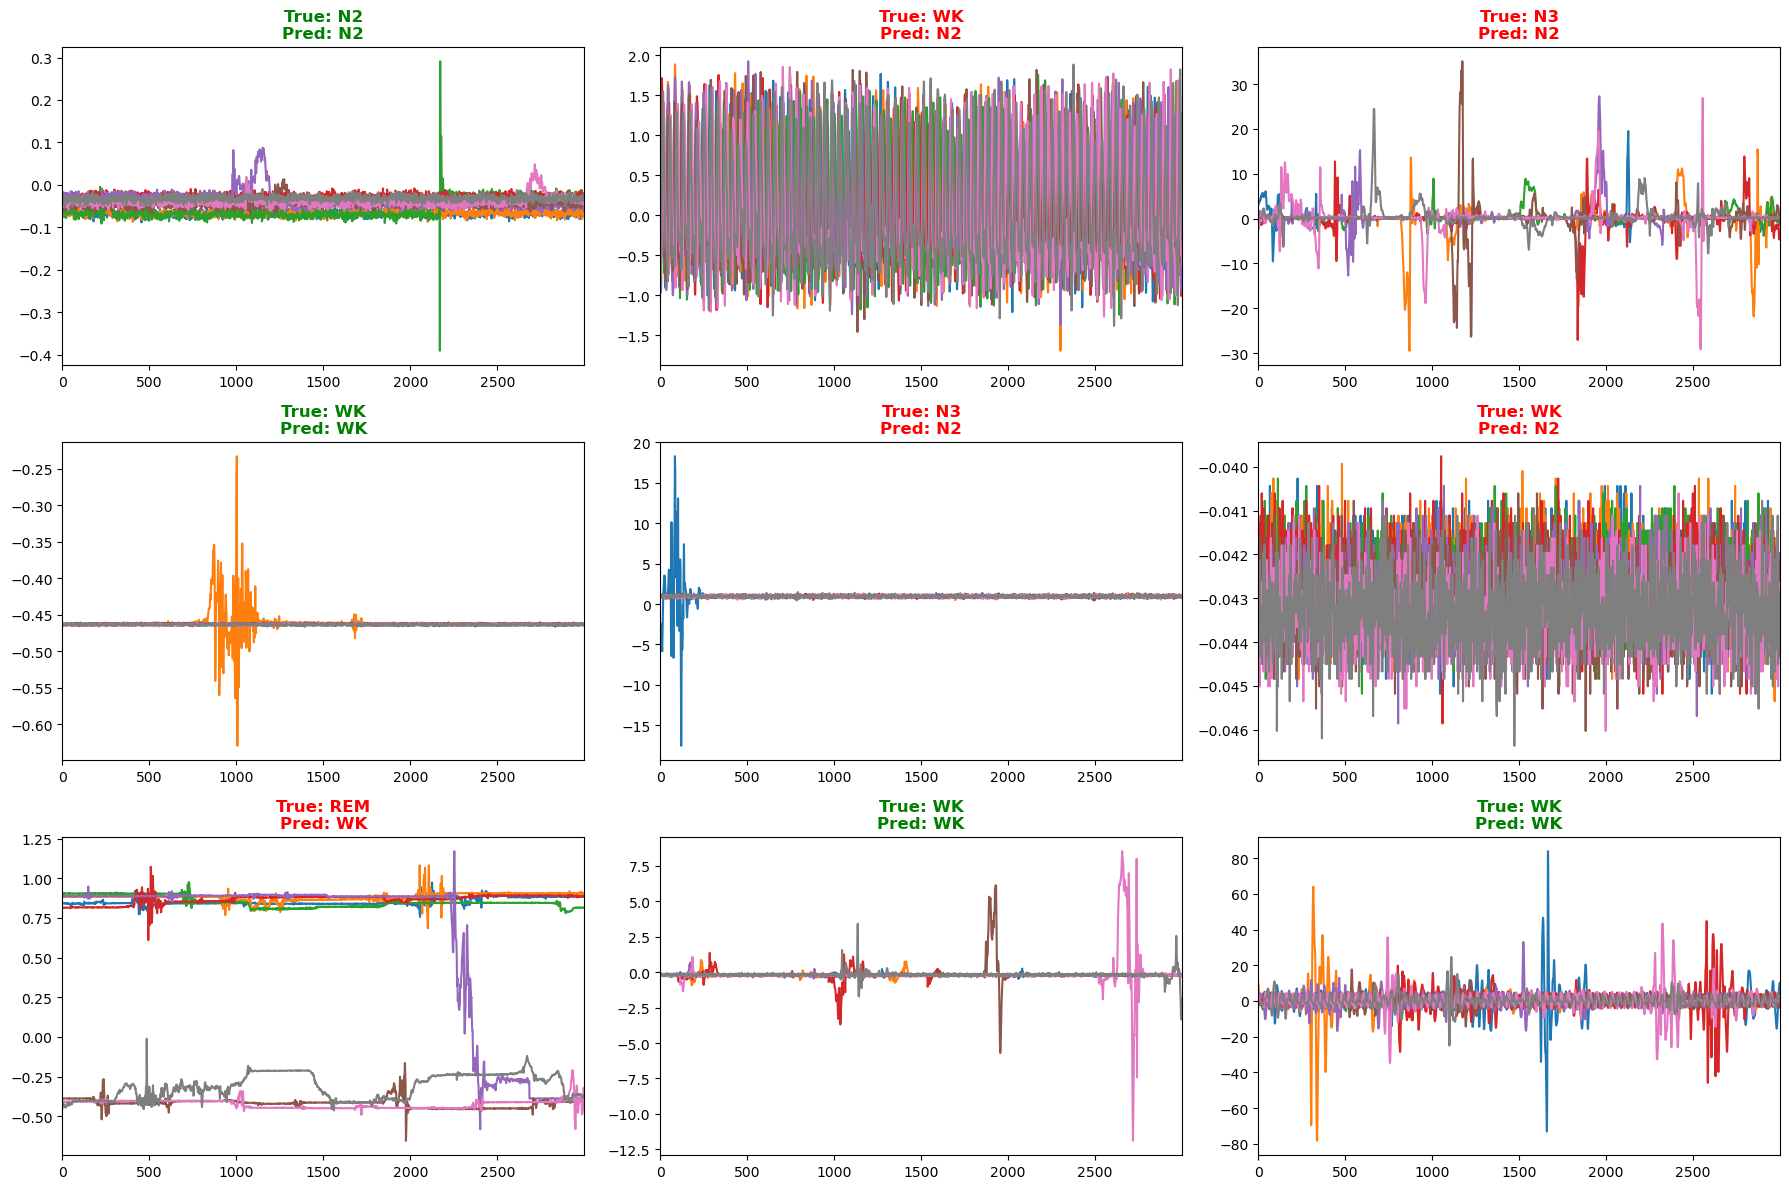

In [ ]:
learn.show_results()


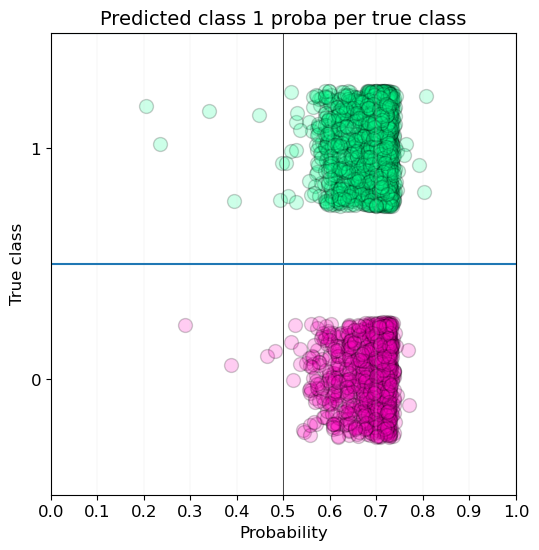

In [ ]:
learn.show_probas()


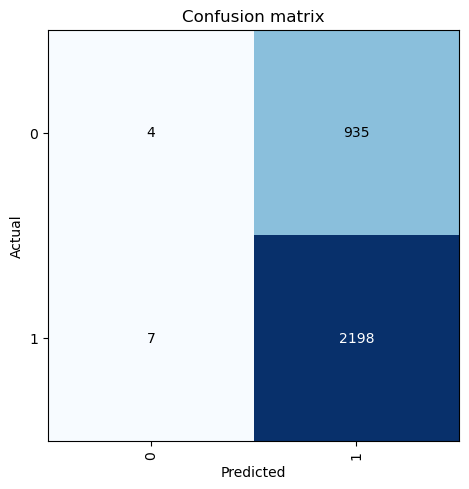

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [ ]:
interp.most_confused(min_val=3)

[(0, 1, 935), (1, 0, 7)]

In [ ]:
print(f'accuracy: {skm.accuracy_score(valid_targets, valid_preds):10.6f}')

accuracy:   0.700382


# inference on unseen data

In [ ]:
# Read the data
test_data = pd.read_csv('final_test_processed.csv', index_col=0)

# select the columns
test_data = test_data[['ledGreen', 'accelerometer', 'gyroscope', 'hr',
                'sleep_state']].interpolate(method='spline', order=4).dropna()

# drop rows where 'hr' column have values starting with '['
test_data = test_data[~test_data['hr'].str.startswith('[', na=False)]

test_data.reset_index(drop=True, inplace=True)

In [ ]:
test_data

,ledGreen,accelerometer,gyroscope,hr,sleep_state
0,81.099061,4193.748204,227.129919,7.871621,0
1,448.425521,4188.334066,234.546904,6.814756,0
2,1158.939516,4182.935453,243.854465,6.344712,0
3,1915.355496,4185.416526,232.191731,6.601495,0
4,2313.691734,4187.903891,220.827987,7.252714,0
...,...,...,...,...,...
1726495,2.509672,4034.785744,263.024714,13.990475,1
1726496,5.263592,4036.533352,259.495665,13.193912,1
1726497,7.742607,4038.286023,257.631520,12.688979,1
1726498,9.844872,4038.391842,255.610381,12.523456,1


In [ ]:
scaler = RobustScaler()
le = LabelEncoder()

X_test = scaler.fit_transform(test_data[['ledGreen', 'accelerometer', 'gyroscope', 'bpm', 'breathingrate', 'hr']])
y_test = le.fit_transform(test_data['sleep_state'])

pd.DataFrame(X_test)

KeyError: "['bpm', 'breathingrate'] not in index"

In [ ]:
# epoch lenght 60 seconds (25hz * 60 = 1500)
sh = len(X_test)//1500 

X_test = X_test.T.reshape(sh, 6, 1500)
y_test = y_test.T.reshape(sh, 1500)
y_test = (y_test.sum(axis=1) // 1500).reshape(-1, 1).flatten()

X_test.shape, y_test.shape

((1145, 6, 1500), (1145,))

In [ ]:
# Labelled test data
test_ds = valid_dl.dataset.add_test(
    X_test, y_test)  # In this case I'll use X and y, but this would be your test data
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:128, vars:6, len:1500, device=cuda:0, dtype=torch.float32),
 TensorCategory([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'))

In [ ]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl,
                                                        with_decoded=True,
                                                        save_preds=None,
                                                        save_targs=None)
test_probas, test_targets, test_preds


(tensor([[0.1701, 0.8299],
         [0.1699, 0.8301],
         [0.1701, 0.8299],
         ...,
         [0.1833, 0.8167],
         [0.1817, 0.8183],
         [0.1822, 0.8178]]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([1, 1, 1,  ..., 1, 1, 1]))

In [ ]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')

accuracy:   0.772052


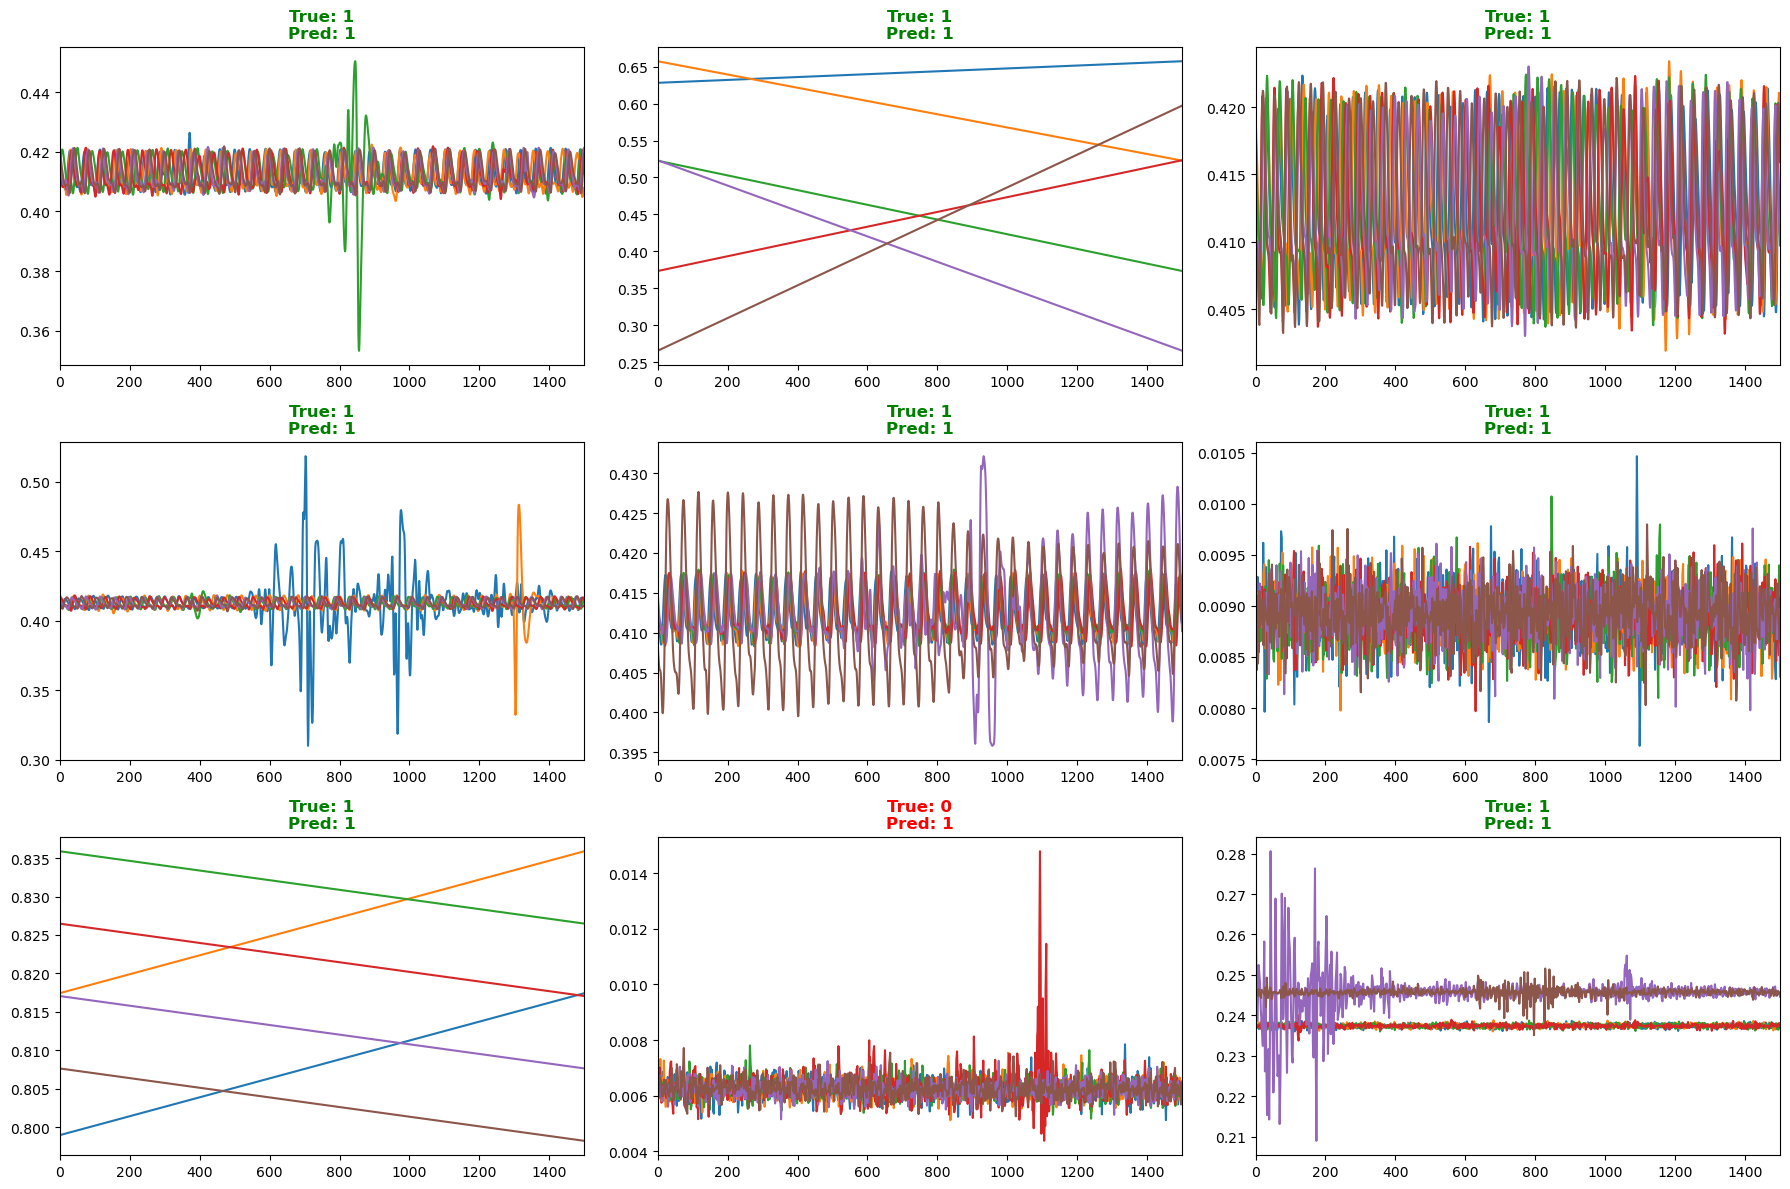

In [ ]:
learn.show_results()


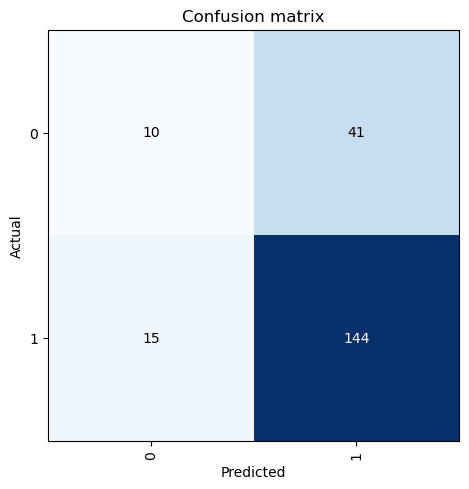

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### If unlabelled data

In [ ]:
# Unlabelled data
test_ds = dls.dataset.add_test(X)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

In [ ]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas
